# Users on YouTube : who they are, what they do

The purpose of this notebook is to investigate user profiles. We take 3 main datasets; the youtube_comment, yt_metadata_helper and df_channels_en datasets to build new tables that will help us understand users habits.

The notebook is separated in two distinct parts: 
- The first half is mostly exploration. We do visualization, reason about the dataset, compute metrics. 
- The second half is oriented towards the data's story main question: we aim to characterize the groups. We define the space they live in, how we define them and what they are. 

In [ ]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import gzip
import subprocess
import itertools
import hashlib
import math 
import random
import heapq
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
from pathlib import Path

from utils.community_helper import (
    export_heatmap_2d,
    build_author_channelid_comment_counts,
    build_author_groups_and_group_channels,
    compute_groups_num_authors,
    compute_groups_num_channels,
    compute_groups_total_comments,
    build_group_features,
    category_analysis_for_groups,
    export_group_histograms,
    export_feature_distributions,
    run_kmeans_on_groups,
    summarize_kmeans_cluster_people_share,
    plot_kmeans_clusters,
    export_kmeans_explorer_assets,
    export_kmeans_people_share_json,
    show_output_summary, 
    ensure_author_namecc_comment_counts, 
    ensure_author_groups_and_patterns, 
    stream_author_activity_stats, 
    stream_group_concentration_stats, 
    plot_preliminary_scale_concentration, 
    run_a1_summary_and_plots, 
    run_a1_noise_and_singleton_diagnostics, 
    run_a1_extras, 
    run_a1_extra_plots, 
    load_or_compute_group_sizes
)

# Part 1: Exploration

In [ ]:
# Notebook is run from: ~/Desktop/youniverse/custom/notebook
BASE_DIR = Path(".").resolve()
ANALYSIS_DIR = BASE_DIR / "analysis_out"
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
MODELS_DIR = DATA_DIR / "models"

# Derived outputs (same directory you used before)
DERIVED_DIR = BASE_DIR / "derived"
DERIVED_DIR.mkdir(parents=True, exist_ok=True)


BASE_DIR   = True /Users/matteo/Desktop/youniverse/custom/notebook
DERIVED_DIR = True /Users/matteo/Desktop/youniverse/custom
ANALYSIS_DIR = True /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out
comments   = True /Users/matteo/Desktop/youniverse/big/youtube_comments.tsv.gz
meta       = True /Users/matteo/Desktop/youniverse/helper/yt_metadata_helper.feather
channels   = True /Users/matteo/Desktop/youniverse/processed/df_channels_en.tsv.gz
output     = /Users/matteo/Desktop/youniverse/custom/author_namecc_comment_counts.tsv.gz


# 1.1 Preprocessing


Goal of preprocessing:
1) Build author_namecc_comment_counts.tsv.gz
   Each row = (author, channel_name_cc, count_comments_from_author_on_that_channel)

2) Sort it by (author, name_cc) so that we can stream group construction.

3) Build groups:
   - author_groups.tsv.gz       : (author -> group_id)
   - groups_channel_numc.tsv.gz  : for each group_id, the channels it commented on + aggregated counts
     (This is the "signature" of the group: which channels and how much.)

4) Convert author_groups.tsv.gz into A1_groups_num_authors.tsv.gz (group_id -> num_authors).

These steps are expensive because the comment dataset is huge; the whole point is to do them in streaming mode.

In [ ]:
# Raw inputs 
comments_path = (RAW_DIR / "youtube_comments.tsv.gz").resolve()
meta_path     = (RAW_DIR / "yt_metadata_helper.feather").resolve()
channels_path = (RAW_DIR / "df_channels_en.tsv.gz").resolve()

# Optional: quick sanity checks / peek at helper metadata (lightweight)
if meta_path.exists():
    df_meta = pd.read_feather(meta_path)
    display(df_meta.head())
else:
    print("Missing meta_path:", meta_path)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,779.0,oB4c-yvnbjs,1394,1607.0,2016-09-28,1800602.0
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,24.0,ZaV-gTCMV8E,5064,227.0,2016-09-28,57640.0
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,13.0,cGvL7AvMfM0,3554,105.0,2016-09-28,86368.0


Step 1: Build author_namecc_comment_counts.tsv.gz

This file is typically produced by streaming youtube_comments.tsv.gz and aggregating
(author, channel_name_cc) -> count.

IMPORTANT: This is the heaviest step. If the output file already exists, this cell will skip.

In [ ]:
total_lines_comments = 8_600_000_000  # for tqdm only; not required for correctness
output_path = DERIVED_DIR / "author_namecc_comment_counts.tsv.gz"


ensure_author_namecc_comment_counts(
    comments_path=comments_path,
    meta_path=meta_path,
    channels_path=channels_path,
    output_path=output_path,
    total_lines_comments=total_lines_comments,
)


File already exists, skipping this step.
Path: /Users/matteo/Desktop/youniverse/custom/author_namecc_comment_counts.tsv.gz
Number of lines (excluding header): 3508299157

Head (first 10 rows):


,author,name_cc,num_comments
0,1,123 GO!,1
1,1,SSSniperWolf,2
2,1,Sebastian Bails,1
3,1,OMG Blast,1
4,2,Draw So Cute,1
5,2,FaZe Banks,1
6,2,Ali-A,1
7,3,ABS-CBN Entertainmen...,2
8,4,Cracked,1
9,4,Mark Dice,1


This new dataset we created enumerates all authors (or rather, their unique ID). For each, it lists all channels they commented on, and how many comments they posted on that channel. This 
table is the foundation of our next steps. 

We will now form *groups* of users. Users are groupped together if they have the exact same comment profile, ie they commented the same number of times on the same channels. 

In [5]:
input_path = output_path  # author_namecc_comment_counts.tsv.gz

out_author_groups = DERIVED_DIR / "author_groups.tsv.gz"
out_groups_pattern = DERIVED_DIR / "groups_channel_numc.tsv.gz"

TOTAL_DATA_ROWS = 3_508_299_157  # number of data rows (excluding header)

ensure_author_groups_and_patterns(
    input_path=input_path,
    out_author_groups=out_author_groups,
    out_groups_pattern=out_groups_pattern,
    total_data_rows=TOTAL_DATA_ROWS,
)


Group files already exist, skipping grouping step.
Path: /Users/matteo/Desktop/youniverse/custom/author_groups.tsv.gz
Number of lines (excluding header): 448807699

Head (first 8 rows):


,author,group
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
5,7,5
6,9,6
7,10,7


Path: /Users/matteo/Desktop/youniverse/custom/groups_channel_numc.tsv.gz
Number of lines (excluding header): 3238439973

Head (first 8 rows):


,group,channel,num_comments
0,0,123 GO!,1
1,0,OMG Blast,1
2,0,SSSniperWolf,2
3,0,Sebastian Bails,1
4,1,Ali-A,1
5,1,Draw So Cute,1
6,1,FaZe Banks,1
7,2,ABS-CBN Entertainmen...,2


author_groups.tsv is the table that maps each author to the group they belong to. 

groups_channel_numc.tsv is crucial; it describes the comment profile of every group. Meaning, for each group, just like in the very first table, it tells us what channel that group commented on, and how many times. Note that this time, it's at the group level, not at the user level!

# 1.2 Author-level activity 

In [7]:
# Exploratory metrics: activity, concentration, heavy tails
# (streaming + reservoir sampling, single pass per dataset)

random.seed(42)

print("\n=== Exploratory metrics ===")

# 1) Author-level activity

def summarize(x):
    x = sorted(x)
    n = len(x)
    return {
        "min": min(x),
        "median": x[n // 2],
        "p90": x[int(0.90 * n)],
        "p99": x[int(0.99 * n)],
        "max": max(x),
        "mean": sum(x) / n,
    }


if output_path.exists():
    n_authors_seen, totals_sample, nchannels_sample = stream_author_activity_stats(output_path)

    print("\n[Author-level activity]")
    print("Authors seen:", f"{n_authors_seen:,}")
    print("Sample size:", f"{len(totals_sample):,}")

    print("\nTotal comments per author (sampled):")
    for k, v in summarize(totals_sample).items():
        print(f"  {k:>6}: {v:,.2f}")

    print("\nChannels per author (sampled):")
    for k, v in summarize(nchannels_sample).items():
        print(f"  {k:>6}: {v:,.2f}")

    totals_sorted = sorted(totals_sample, reverse=True)
    top1pct = max(1, len(totals_sorted) // 100)
    share_top1 = sum(totals_sorted[:top1pct]) / sum(totals_sorted)

    print(f"\nShare of total comments by top 1% authors (sample): {share_top1:.3f}")

    # Save for plotting
    author_totals_sample = totals_sample
    author_nchannels_sample = nchannels_sample


# 2) Group-level concentration

if DERIVED_DIR.joinpath("groups_channel_numc.tsv.gz").exists():
    groups_channel_numc_path = DERIVED_DIR / "groups_channel_numc.tsv.gz"

    n_groups_seen, group_top1_share_sample, group_nchannels_sample = (
        stream_group_concentration_stats(groups_channel_numc_path)
    )

    print("\n[Group-level concentration]")
    print("Groups seen:", f"{n_groups_seen:,}")
    print("Sample size:", f"{len(group_top1_share_sample):,}")

    print("\nTop-1 channel share within group (sample):")
    for k, v in summarize(group_top1_share_sample).items():
        print(f"  {k:>6}: {v:,.2f}")

    print("\nChannels per group (sample):")
    for k, v in summarize(group_nchannels_sample).items():
        print(f"  {k:>6}: {v:,.2f}")

    frac_single = (pd.Series(group_nchannels_sample) == 1).mean()
    print(f"\nFraction of single-channel groups (sample): {frac_single:.3f}")

    # Save for plotting, like before
    group_top1_share_plot = group_top1_share_sample
    group_nchannels_plot = group_nchannels_sample



=== Exploratory metrics ===


Author activity scan: 0rows [00:00, ?rows/s]


[Author-level activity]
Authors seen: 448,807,699
Sample size: 2,000,001

Total comments per author (sampled):
     min: 1.00
  median: 2.00
     p90: 30.00
     p99: 296.00
     max: 27,726.00
    mean: 19.18

Channels per author (sampled):
     min: 1.00
  median: 2.00
     p90: 16.00
     p99: 102.00
     max: 1,940.00
    mean: 7.84

Share of total comments by top 1% authors (sample): 0.392


Group concentration scan: 0rows [00:00, ?rows/s]


[Group-level concentration]
Groups seen: 216,933,474
Sample size: 2,000,001

Top-1 channel share within group (sample):
     min: 0.01
  median: 0.33
     p90: 0.62
     p99: 0.88
     max: 1.00
    mean: 0.35

Channels per group (sample):
     min: 1.00
  median: 5.00
     p90: 32.00
     p99: 154.00
     max: 2,050.00
    mean: 14.91

Fraction of single-channel groups (sample): 0.004


## 1.3 Let's visualize these preliminary results : 

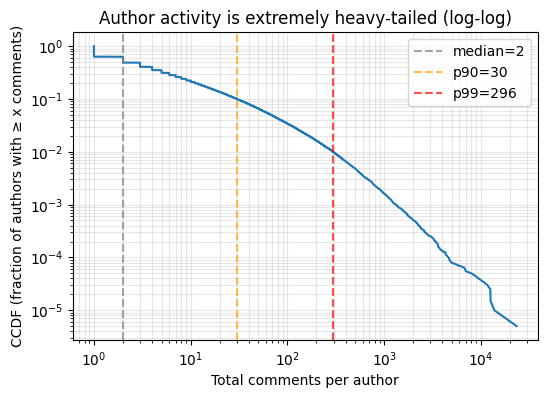

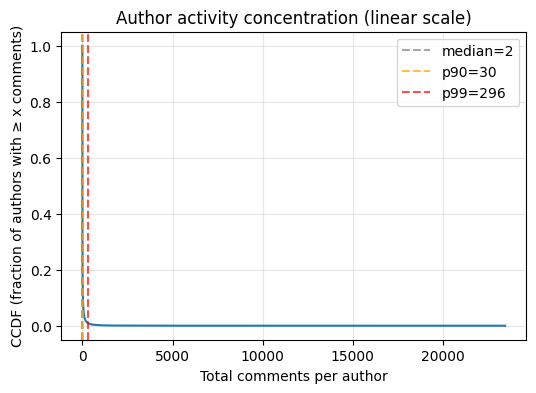

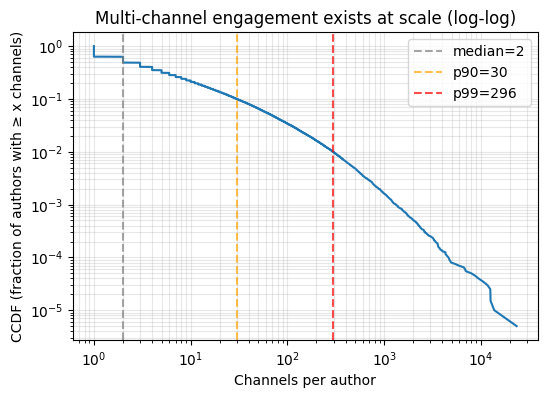

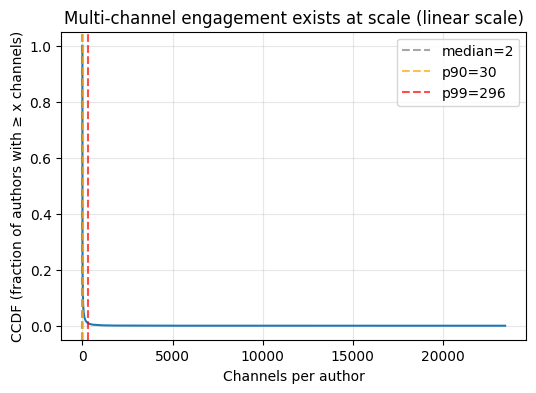

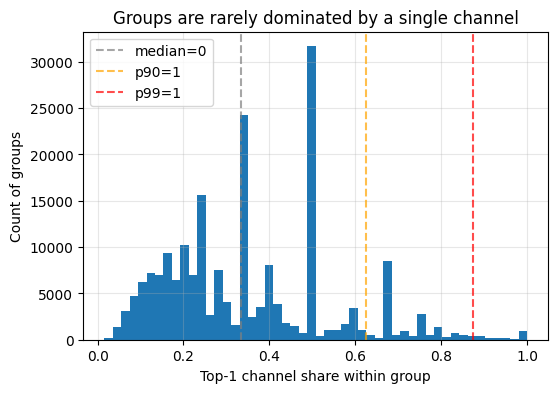

In [8]:
plot_preliminary_scale_concentration(
    author_totals_sample=author_totals_sample,
    author_nchannels_sample=author_nchannels_sample,
    group_top1_share_sample=group_top1_share_sample,
)

## First-look insights on authors and groups

Even before any structural analysis, the raw activity statistics already reveal a highly uneven ecosystem. This is visible both in the summary metrics and in the exploratory distributions shown above.

At the author level, activity is extremely concentrated. While the median author writes only 2 comments across 2 channels, the top 1% of authors account for nearly 40% of all comments. This imbalance is clearly visible in the CCDF plots of total comments per author and channels per author. On a log–log scale, the curves extend smoothly over several orders of magnitude, indicating very heavy tails. On a linear scale, the same distributions show that the vast majority of authors are tightly clustered near the minimum activity levels, with only a small fraction contributing large volumes of comments.

The vertical reference lines (median, p90, p99) make this concentration concrete: by the time we reach the 99th percentile, authors are already posting hundreds of comments and interacting with dozens of channels. Beyond that point lies a long tail of extreme users posting tens of thousands of comments and engaging with hundreds or even thousands of channels.

At the group level, we observe a different but complementary phenomenon. Although many individual authors comment on only one channel, single-channel groups are extremely rare (≈0.4% of groups). This apparent paradox is explained by the grouping process itself: groups represent shared behavioral patterns, so many low-activity authors collapse into a small number of identical, trivial groups. The distribution of channels per group confirms that meaningful structural diversity arises primarily from multi-channel engagement, with a median of about 5 channels per group and a long tail extending to hundreds or even thousands.

The histogram of top-1 channel share within groups further shows that most groups are not dominated by a single channel. Instead, activity is typically spread across multiple channels, indicating that groups capture genuine cross-channel behavioral structure rather than isolated single-channel behavior.

Taken together, the statistics and the plots indicate that:

- Most authors contribute very little and add limited structural information.

- Most meaningful structure comes from a minority of highly active, multi-channel users.

- Raw distributions are dominated by noise from low-activity behavior, which obscures higher-level patterns.

Because of this, filtering and denoising are essential to uncover interpretable structure. In the next section, we therefore move from author-level activity to group-level size distributions, and we will explicitly study how removing low-activity or trivial groups changes the observed structure.

# 1.4 Group size 

In [ ]:
# Group size distribution (load-or-compute)

A1_TABLES = (ANALYSIS_DIR / "tables").resolve()
A1_PLOTS  = (ANALYSIS_DIR / "plots").resolve()
A1_TABLES.mkdir(parents=True, exist_ok=True)
A1_PLOTS.mkdir(parents=True, exist_ok=True)

author_groups_path = (DERIVED_DIR / "author_groups.tsv.gz").resolve()
groups_num_authors_path = (A1_TABLES / "A1_groups_num_authors.tsv.gz").resolve()

print("author_groups_path =", author_groups_path)
print("groups_num_authors_path =", groups_num_authors_path)


groups_df = load_or_compute_group_sizes(
    author_groups_gz=author_groups_path, 
    out_path=groups_num_authors_path
)

display(groups_df.head(10))
print("n_groups =", f"{len(groups_df):,}")
print("total_authors (rows in author_groups) =", f"{groups_df['num_authors'].sum():,}")
print("fraction singleton groups =", (groups_df["num_authors"].eq(1).mean()))

author_groups_path = /Users/matteo/Desktop/youniverse/custom/author_groups.tsv.gz
groups_num_authors_path = /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/tables/A1_groups_num_authors.tsv.gz
[A1] Found cached: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/tables/A1_groups_num_authors.tsv.gz


,group,num_authors
0,493,1550110
1,90,711629
2,1082,704623
3,79,600256
4,567,551964
5,125,495674
6,1013,482208
7,782,453822
8,1344,427104
9,4157,344854


n_groups = 216,933,474
total_authors (rows in author_groups) = 448,807,699
fraction singleton groups = 0.9627757355695138


Wrote: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/tables/A1_summary.tsv


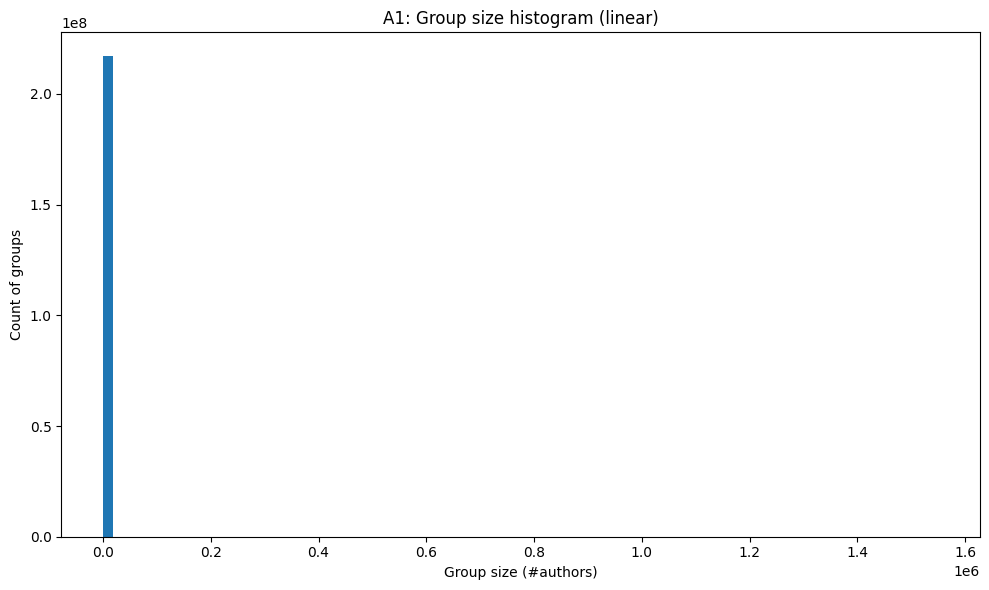

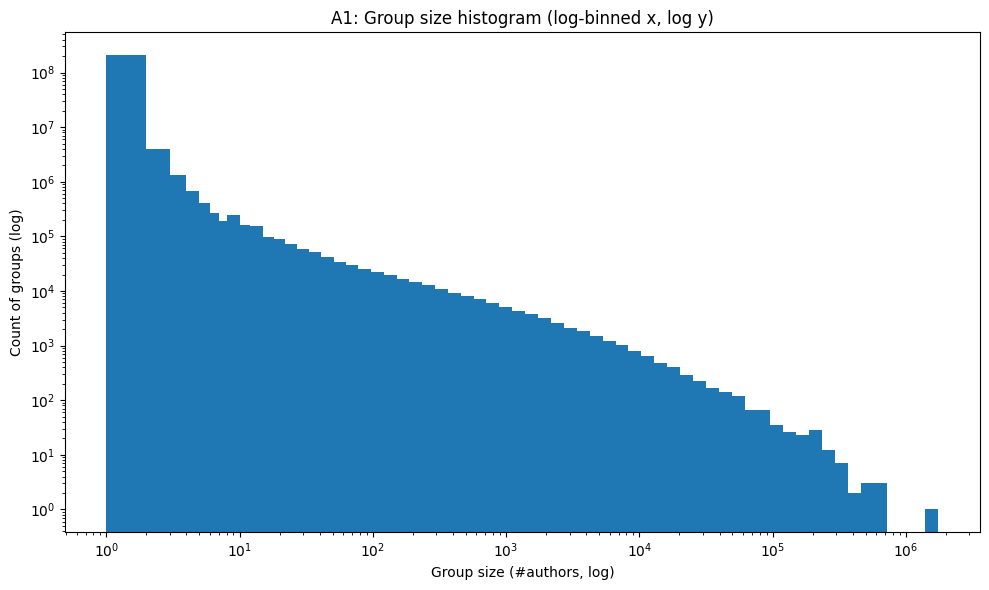

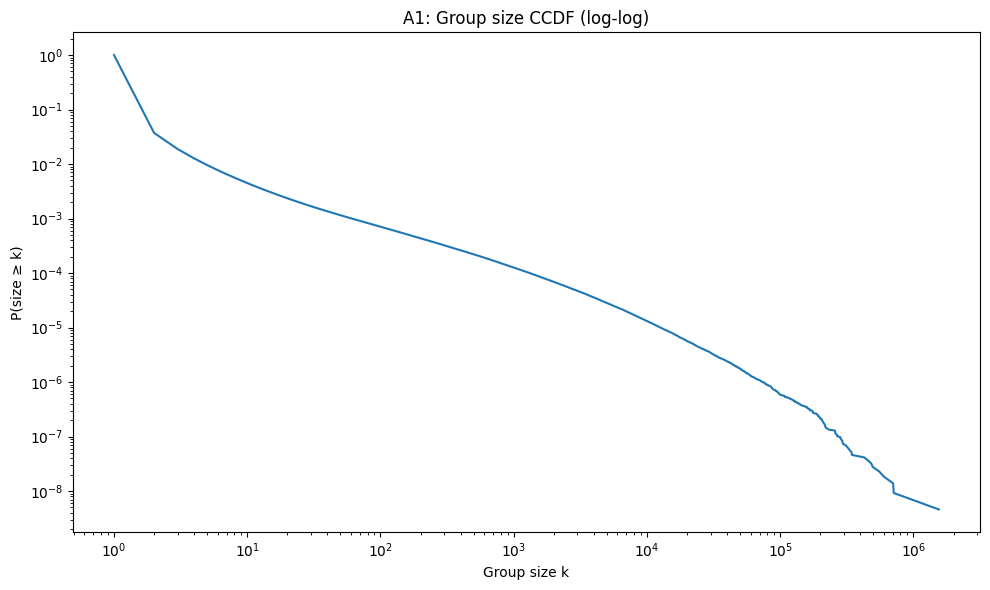

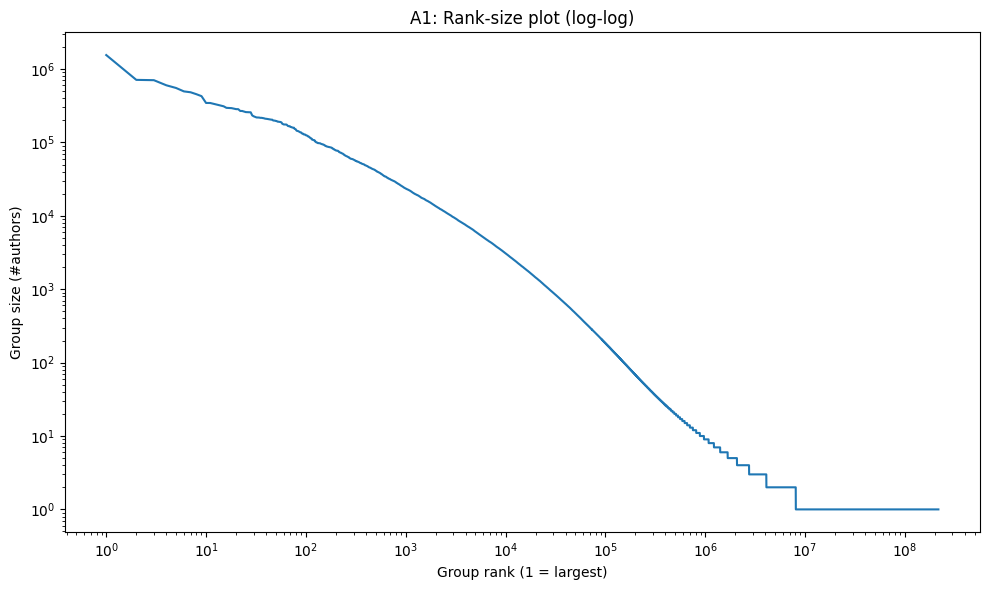

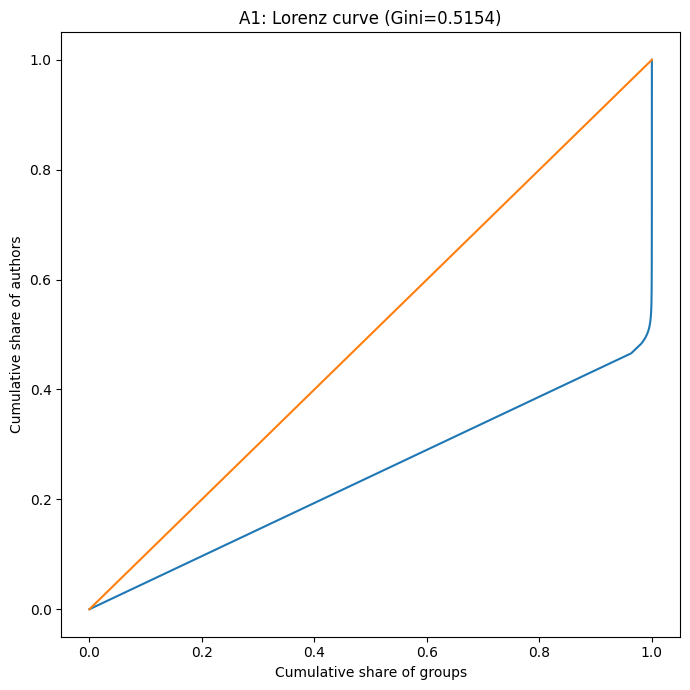

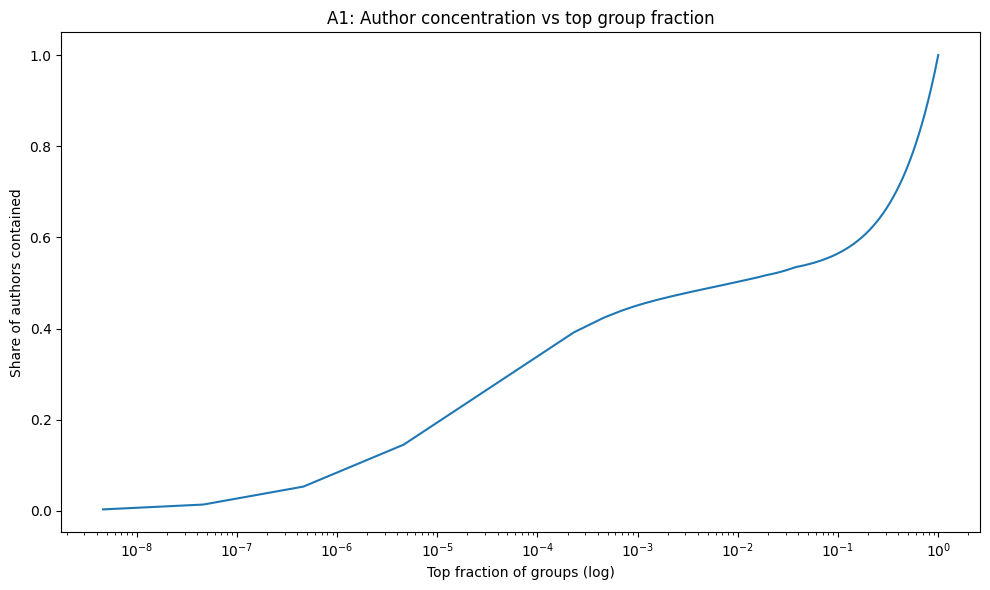

Wrote: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/tables/A1_top_group_shares.tsv
Wrote: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/tables/A1_top_groups_by_size.tsv.gz


,n_groups,n_authors,authors_per_group_mean,median_group_size,p90_group_size,p99_group_size,max_group_size,fraction_groups_singleton,fraction_authors_in_singletons,gini_group_size
0,216933474,448807699,2.068873,1.0,1.0,4.0,1550110,0.962776,0.465363,0.515449


,top_fraction_groups,top_n_groups,share_of_authors
0,0.0001,21693,0.342795
1,0.0010,216933,0.451098
2,0.0100,2169334,0.502734
3,0.0500,10846673,0.540813
4,0.1000,21693347,0.564980


In [10]:
# Summary + plots

results = run_a1_summary_and_plots(
    groups_df=groups_df,
    tables_dir=A1_TABLES,
    plots_dir=A1_PLOTS,
)

summary        = results["summary"]
conc_df        = results["conc_df"]
top_shares_df  = results["top_shares_df"]
groups_sorted  = results["groups_sorted"]

display(summary)
display(top_shares_df)


# 1.5 Singleton analysis 

A1(noise): stream sizes: 0groups [00:00, ?groups/s]

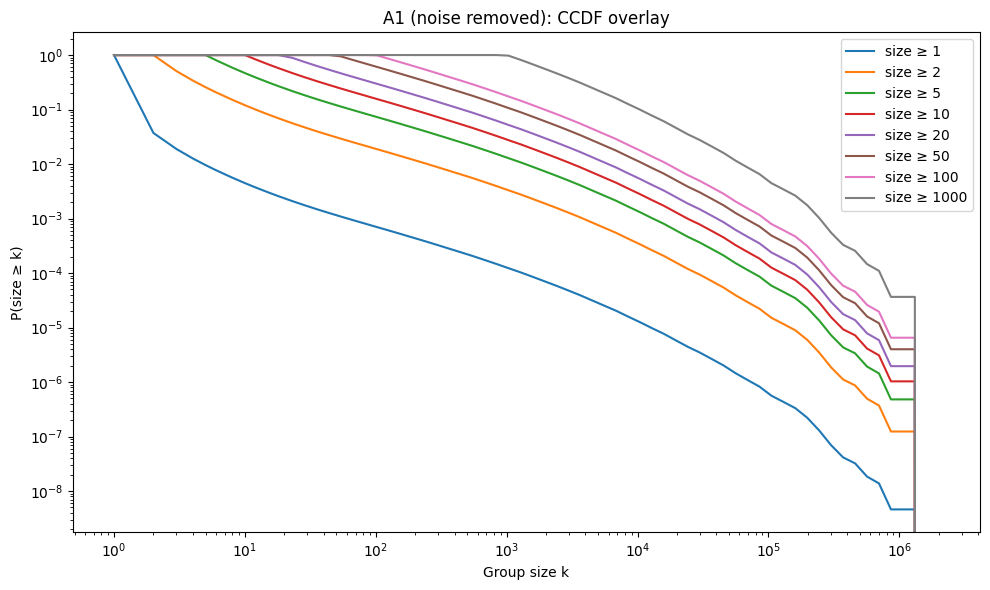

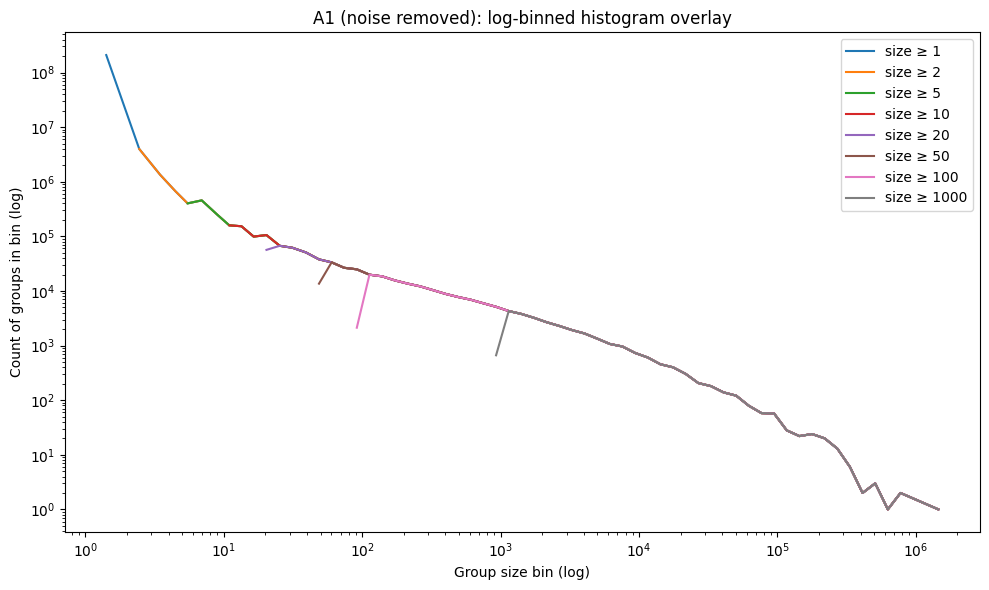

Sample groups (reservoir): 0groups [00:00, ?groups/s]

Scan groups_channel for sampled groups: 0rows [00:00, ?rows/s]

Wrote: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/A1_noise_and_singletons/part2_singleton_vs_non/singleton_vs_non_summary.tsv


,cohort,N,mean_num_channels,median_num_channels,mean_total_comments,median_total_comments,mean_top1_share,median_top1_share,mean_top10_share,median_top10_share
0,singleton,50000,15.48036,6.0,38.68252,9.0,0.341574,0.333333,0.901662,1.0
1,non_singleton,50000,2.07398,2.0,3.08520,2.0,0.577080,0.500000,0.999901,1.0


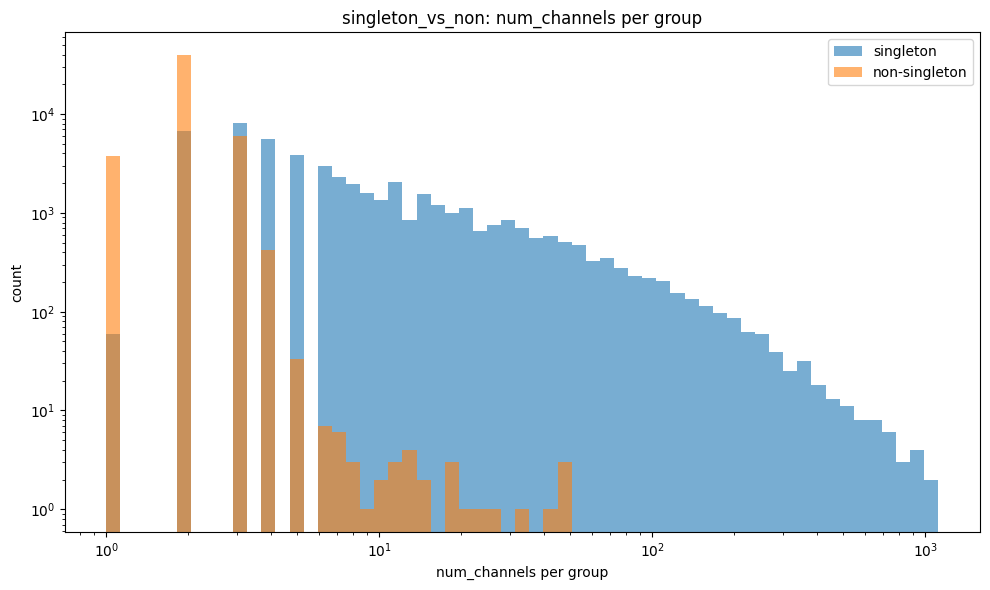

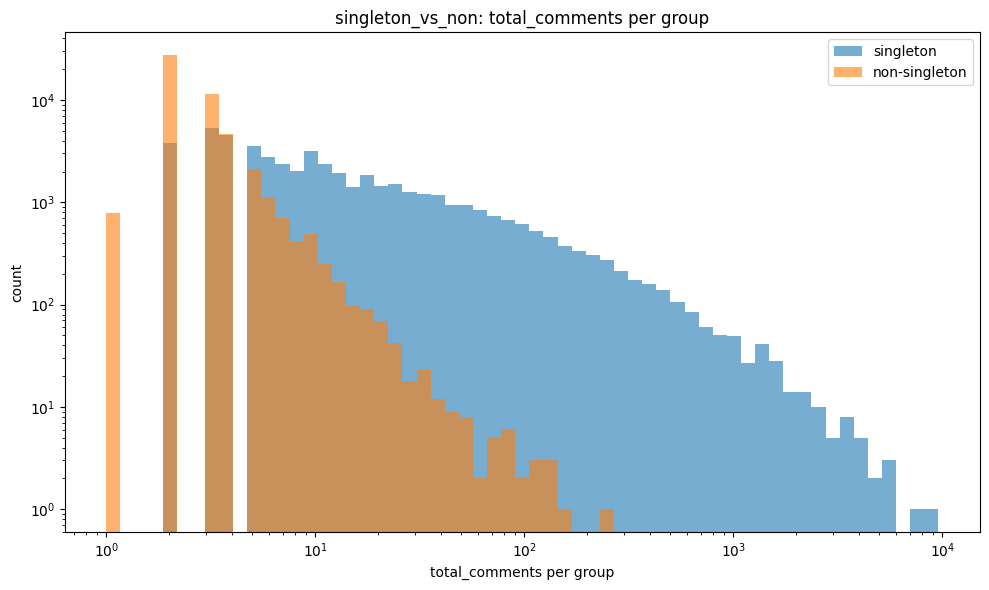

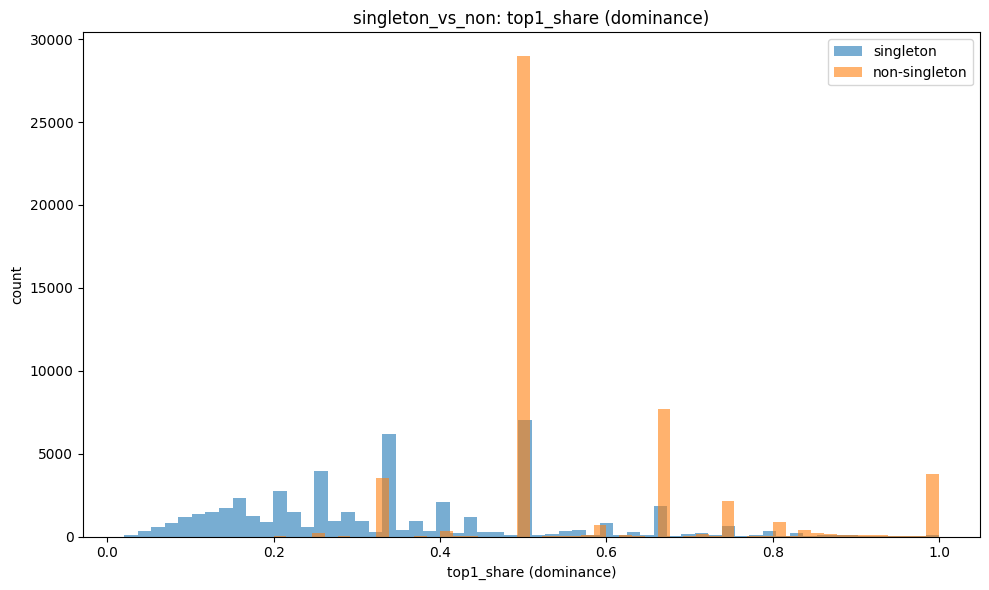

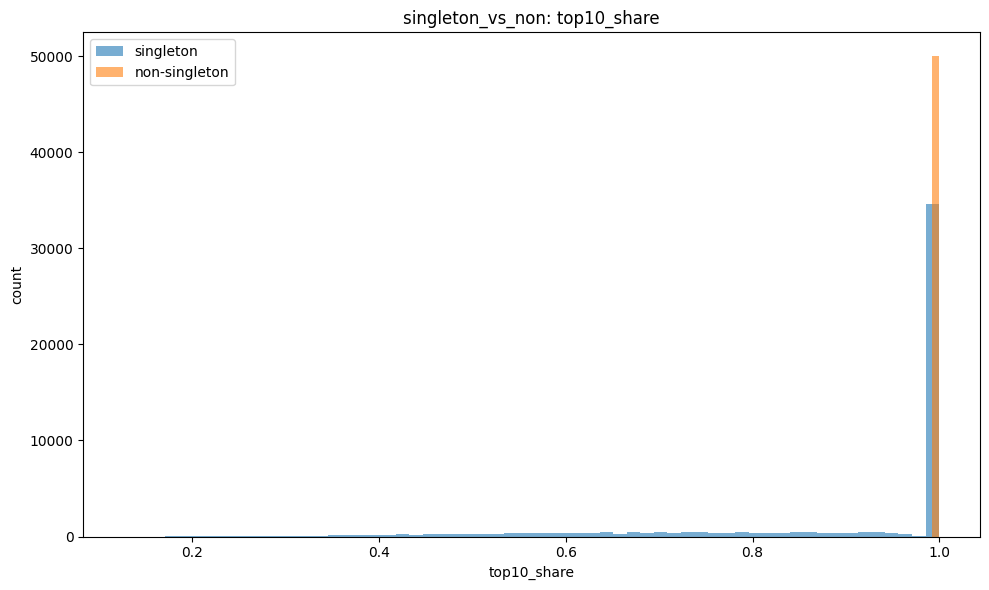

In [11]:
# Denoising + singleton vs non-singleton diagnostics

A1_DIAG_DIR = (ANALYSIS_DIR / "A1_noise_and_singletons").resolve()
PART1_DIR = (A1_DIAG_DIR / "part1_noise_removed").resolve()
PART2_DIR = (A1_DIAG_DIR / "part2_singleton_vs_non").resolve()
PART1_DIR.mkdir(parents=True, exist_ok=True)
PART2_DIR.mkdir(parents=True, exist_ok=True)

groups_channel_numc_path = (DERIVED_DIR / "groups_channel_numc.tsv.gz").resolve()

run_a1_noise_and_singleton_diagnostics(
    groups_num_authors_path=groups_num_authors_path,
    groups_channel_numc_path=groups_channel_numc_path,
    part1_dir=PART1_DIR,
    part2_dir=PART2_DIR,
)


# 1.6 Extra computations

In [ ]:
# Some extra compute:
# (1) coverage table
# (2) top-group enrichment
# (4) denoised overlays

A1_TABLES = ANALYSIS_DIR / "tables"
A1_summary_path = A1_TABLES / "A1_summary.tsv"
top_groups_path = A1_TABLES / "A1_top_groups_by_size.tsv.gz"

groups_channel_numc_path = None
cand1 = (DERIVED_DIR / "groups_channel_numc.tsv.gz") if "DERIVED_DIR" in globals() else None
cand2 = (ANALYSIS_DIR / "groups_channel_numc.tsv.gz")
for c in [cand1, cand2]:
    if c is not None and c.exists():
        groups_channel_numc_path = c.resolve()
        break

OUT_A1X = ANALYSIS_DIR / "A1_extra"
OUT_A1X.mkdir(parents=True, exist_ok=True)

# was: print("A1_DIR:", A1_DIR)
print("A1_TABLES:", A1_TABLES)
print("groups_num_authors:", groups_num_authors_path.exists(), groups_num_authors_path)
print("groups_channel_numc:", groups_channel_numc_path is not None, groups_channel_numc_path)
print("OUT_A1X:", OUT_A1X)

if groups_channel_numc_path is None:
    raise FileNotFoundError("Could not locate groups_channel_numc.tsv.gz (checked DERIVED_DIR / ANALYSIS_DIR).")


# Run extras (reuses groups_df if already present)
results_extras = run_a1_extras(
    groups_num_authors_path=groups_num_authors_path,
    groups_channel_numc_path=groups_channel_numc_path,
    summary_path=A1_summary_path,
    top_groups_path=top_groups_path,
    out_a1x_dir=OUT_A1X,
    groups_df=groups_df if "groups_df" in globals() else None,
)

# Unpack for notebook convenience / later plotting
df_cov = results_extras["coverage"]
df_top_enriched = results_extras["top_enriched"]
df_keep = results_extras["keep"]
A1_sizes_by_K = results_extras["sizes_by_K"]
A1_authors_kept_by_K = results_extras["authors_kept_by_K"]
groups_df = results_extras["groups_df"]  # may be reloaded
TOTAL_GROUPS = results_extras["TOTAL_GROUPS"]
TOTAL_AUTHORS = results_extras["TOTAL_AUTHORS"]

# Show the same summaries as before
display(df_cov)
display(df_top_enriched.head(10))
display(df_keep)

# For any later cells relying on these names:
A1_cov_table = df_cov
A1_top_enriched = df_top_enriched


A1_TABLES: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/tables
groups_num_authors: True /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/tables/A1_groups_num_authors.tsv.gz
groups_channel_numc: True /Users/matteo/Desktop/youniverse/custom/groups_channel_numc.tsv.gz
OUT_A1X: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/A1_extra
TOTAL_GROUPS = 216,933,474
TOTAL_AUTHORS= 448,807,699
Saved: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/A1_extra/A1_topK_group_coverage.tsv
Top groups to enrich: 5000


Enrich top groups (scan groups_channel_numc): 0rows [00:00, ?rows/s]

Saved: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/A1_extra/A1_top_groups_enriched.tsv.gz


Build pass-sets by per-author total: 0rows [00:00, ?rows/s]

K>10: groups passing = 94,151,052
K>20: groups passing = 60,029,485
K>50: groups passing = 29,439,536
K>100: groups passing = 15,383,077
K>200: groups passing = 7,197,732
K>500: groups passing = 2,176,379
K>1000: groups passing = 740,706
Saved: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/A1_extra/A1_keep_by_user_comment_threshold.tsv


,top_k_groups,authors_covered,share_of_all_authors
0,1,1550110,0.003454
1,5,4118582,0.009177
2,10,6322244,0.014087
3,50,16176180,0.036043
4,100,24005559,0.053487
5,500,49949837,0.111295
6,1000,65261621,0.145411
7,5000,109382450,0.243718
8,10000,130704713,0.291227


,group,num_authors,pattern_n_channels,per_author_total_comments,top1_share,top10_share,group_total_comments
0,493,1550110,1,1,1.0,1.0,1550110.0
1,90,711629,1,1,1.0,1.0,711629.0
2,1082,704623,1,1,1.0,1.0,704623.0
3,79,600256,1,1,1.0,1.0,600256.0
4,567,551964,1,1,1.0,1.0,551964.0
5,125,495674,1,1,1.0,1.0,495674.0
6,1013,482208,1,1,1.0,1.0,482208.0
7,782,453822,1,1,1.0,1.0,453822.0
8,1344,427104,1,1,1.0,1.0,427104.0
9,4157,344854,1,1,1.0,1.0,344854.0


,K_threshold,n_groups_kept,n_authors_kept,share_authors_kept,max_group_size_kept
0,10,94151052,94798731,0.211223,3736
1,20,60029485,60154425,0.134032,746
2,50,29439536,29454099,0.065627,90
3,100,15383077,15385926,0.034282,20
4,200,7197732,7198317,0.016039,6
5,500,2176379,2176481,0.004849,2
6,1000,740706,740737,0.001650,2


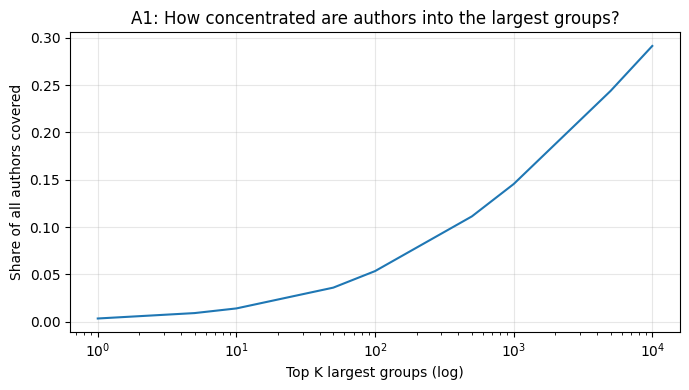

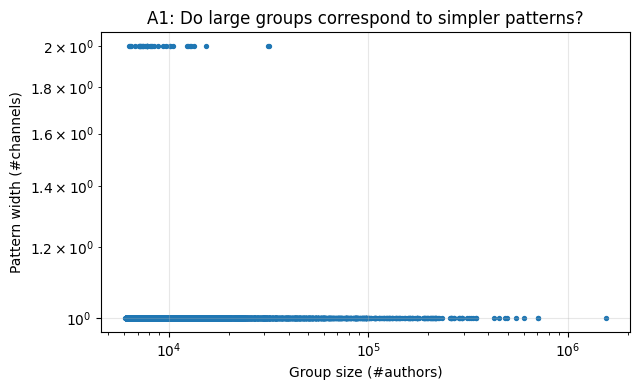

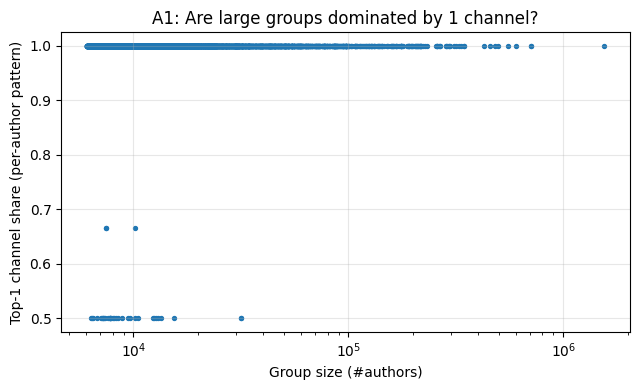

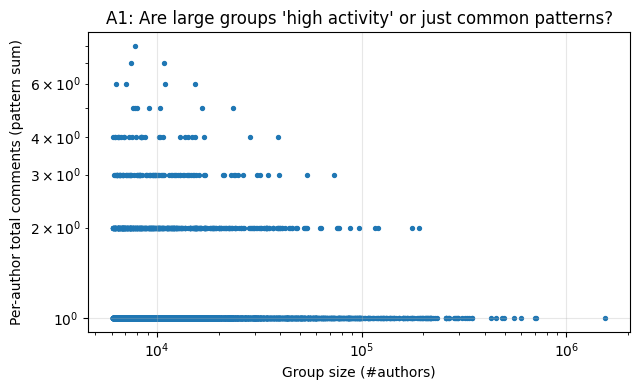

/Users/matteo/Desktop/youniverse/custom/notebook/youniverse_a1_extra_plots.py:133: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/matteo/Desktop/youniverse/custom/notebook/youniverse_a1_extra_plots.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plots_dir / "A1_ccdf_group_size_by_user_comment_threshold.png", dpi=170)
/Users/matteo/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


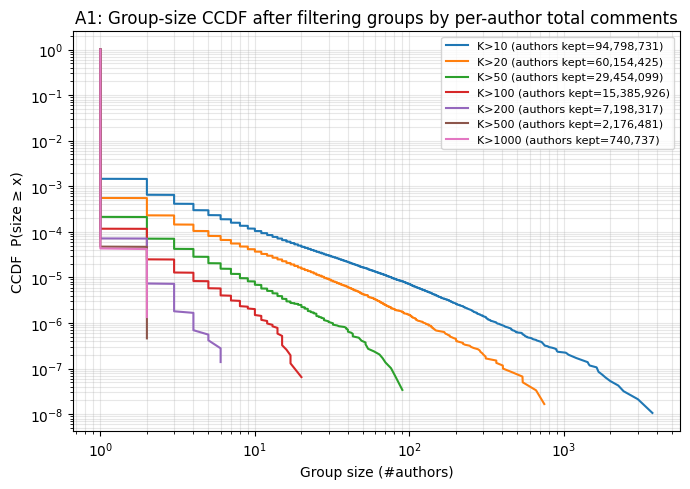

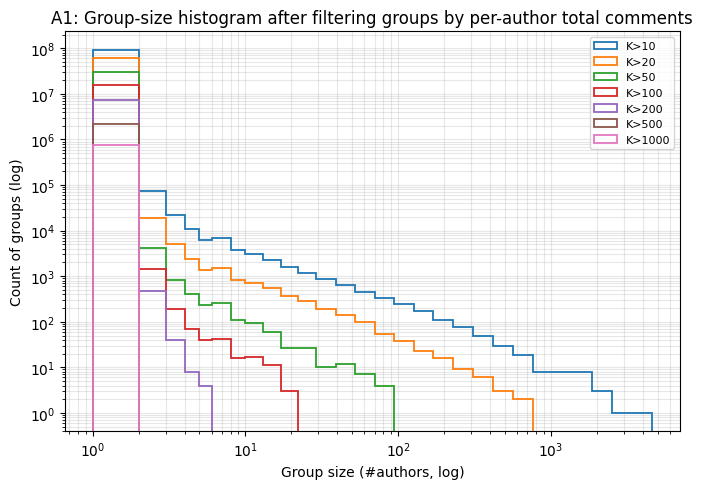

Saved plots to: /Users/matteo/Desktop/youniverse/custom/notebook/analysis_out/A1_extra/plots


In [ ]:
# Extra plots:
# (1) coverage curve
# (2) top-group diagnostics
# (4) denoised overlays by per-author comment threshold
# Reuses: OUT_A1X, A1_cov_table, A1_top_enriched, A1_sizes_by_K, A1_authors_kept_by_K

run_a1_extra_plots(
    out_a1x_dir=OUT_A1X,
    cov_table=A1_cov_table,
    top_enriched=A1_top_enriched,
    sizes_by_K=A1_sizes_by_K,
    authors_kept_by_K=A1_authors_kept_by_K,
)

# We have seen a lot of interesting metrics about groups and how they behave. We now focus our attention to characterizing these groups. 

## 2.1 (New) Data pre-processing

To analyze user commenting behavior, we want to build a dataset with the following structure: author-channel_id-number_of_comments. So for each author, we want to know how many comments they made on each channel.
We only keep the number of comments and not the likes and replies. Like and replies are made by other users, so they do not directly reflect the commenting behavior of the author themselves. (but they could be useful for other analyses). Discarding likes and replies and grouping by channels significantly reduces the dataset size, making it more manageable for analysis. The files size goes from 70 gb to 50 gb, which is already a big improvement. We also sort the dataset by author, and then by channel_id, which will be useful for later data processing steps.

In [ ]:
# ## 1.1 Data pre-processing

comments_path = "../Dataset/original/youtube_comments.tsv.gz"
meta_path = "../Dataset/original/yt_metadata_helper.feather"
author_channel_out = "../Dataset/custom_3/author_channelid_comment_counts.tsv.gz"

total_lines_comments = 8_600_000_000  # for tqdm; not required for correctness

build_author_channelid_comment_counts(
    comments_path=comments_path,
    meta_path=meta_path,
    output_path=author_channel_out,
    total_lines_comments=total_lines_comments,
)


In [ ]:
author_ch = pd.read_csv(author_channel_out, sep="\t", compression="infer", chunksize=10_000)
first_author_ch = next(author_ch)
print(first_author_ch)


## 2.2 Groups of authors

### 2.2.1 Building the groups

Since many authors exhibit similar commenting behaviors, we can group them based on the channels they comment on and the number of comments they make. We define a "group" as a unique combination of channel IDs and their corresponding comment counts. For example, if two authors both commented 5 times on channel A and 3 times on channel B, they belong to the same group. This grouping helps us identify patterns in user behavior and reduces the complexity of the dataset.

We build two output files:
- author_groups.tsv.gz: This file maps each author to their corresponding group ID.
- groups_channelid_numc.tsv.gz: For each group ID, this file lists the channel IDs and the number of comments associated with that group.

To efficiently group authors, we process the sorted author-channel_id-comment_counts dataset in chunks. For each author, we create a unique signature based on their channel-comment count pairs. We use a dictionary to map these signatures to group IDs. If a signature is new, we assign it a new group ID and record the associated channel-comment counts. This approach ensures that authors with identical commenting patterns are grouped together.

total row: 3239637783, number of groups: 216979127, number of author: 576552020

In [ ]:
# ## 2.2 Groups of authors
# ### 2.2.1 Building the groups

author_channel_path = author_channel_out
author_groups_path = (MODELS_DIR / "author_groups.tsv.gz").resolve()
groups_channelid_numc_path = (MODELS_DIR / "groups_channelid_numc.tsv.gz").resolve()

build_author_groups_and_group_channels(
    path=author_channel_path,
    author_groups_path=author_groups_path,
    groups_channelid_numc_path=groups_channelid_numc_path,
    chunksize=1_000_000,
    total_lines=3_509_000_000,
)

### 2.2.2 Number of authors per group

To understand the distribution of authors across different groups, we calculate the number of unique authors in each group. This information helps us identify which groups are more popular or common among authors, and it can provide insights into user behavior patterns on the platform.

In [ ]:
out_path = (MODELS_DIR / "groups_num_authors.tsv.gz").resolve()
compute_groups_num_authors(
    author_groups_path=author_groups_path,
    out_path=out_path,
)

groups_nauthor = pd.read_csv(out_path, sep="\t", compression="infer")
groups_nauthor.head()


### 2.2.3 Number of channels per group

In [ ]:
import gzip
import csv
from tqdm.notebook import tqdm

input_path  = (MODELS_DIR / "groups_channelid_numc.tsv.gz").resolve()
output_path = (MODELS_DIR / "groups_num_channels.tsv.gz").resolve()

total_lines = 3_509_000_000


compute_groups_num_channels(
    groups_channelid_numc_path=input_path,
    out_path=output_path,
    total_lines=3_509_000_000,  # or None if you don't care about tqdm
)



### 2.2.4 Total number of comments per group

We calculate the total number of comments made by all authors within each group. This metric provides insights into the overall activity level of each group, helping us understand how engaged the authors in each group are with the channels they comment on.

In [ ]:
import gzip
import csv
from tqdm import tqdm

input_path  = (MODELS_DIR / "groups_channelid_numc.tsv.gz").resolve()
output_path = (MODELS_DIR / "groups_total_comments.tsv.gz").resolve()

compute_groups_total_comments(
    groups_channelid_numc_path=input_path,
    out_path=output_path,
    total_lines=3_509_000_000,
)


## 2.3 Group visualization

Now that we have built the groups, we can visualize some statistics about them. We will look at the distribution of group sizes (number of authors per group), total number of comments per group, and number of channels per group.

### 2.3.1 Plots

Here are some plots to visualize the distributions of the group features we computed earlier.

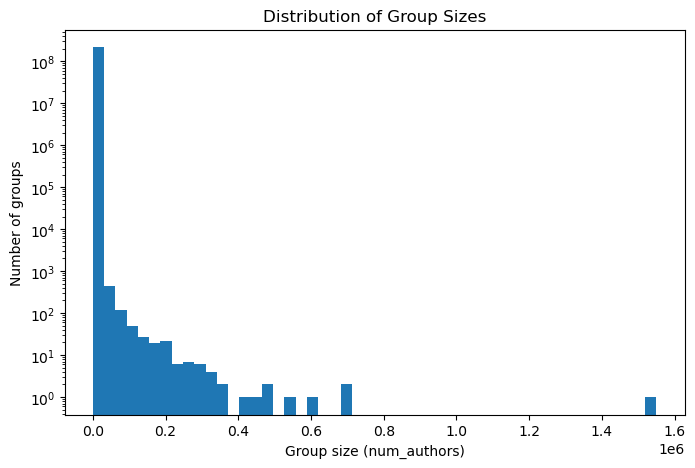

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

groups_nauthor_path = (MODELS_DIR / "groups_num_authors.tsv.gz").resolve()

groups_nauthor = pd.read_csv(groups_nauthor_path, sep="\t", compression="infer")

plt.figure(figsize=(8, 5))
plt.hist(groups_nauthor["num_authors"], log=True, bins=50)
plt.xlabel("Group size (num_authors)")
plt.ylabel("Number of groups")
plt.title("Distribution of Group Sizes")
plt.show()

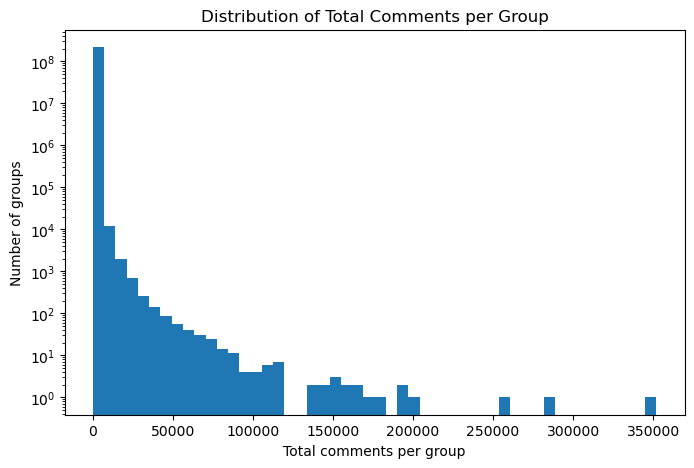

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

groups_total_comments_path = (MODELS_DIR / "groups_total_comments.tsv.gz").resolve()

total_c = pd.read_csv(
    groups_total_comments_path,
    sep="\t",
    compression="infer"
)

plt.figure(figsize=(8, 5))
plt.hist(total_c["total_comments"], log=True, bins=50)
plt.xlabel("Total comments per group")
plt.ylabel("Number of groups")
plt.title("Distribution of Total Comments per Group")
plt.show()

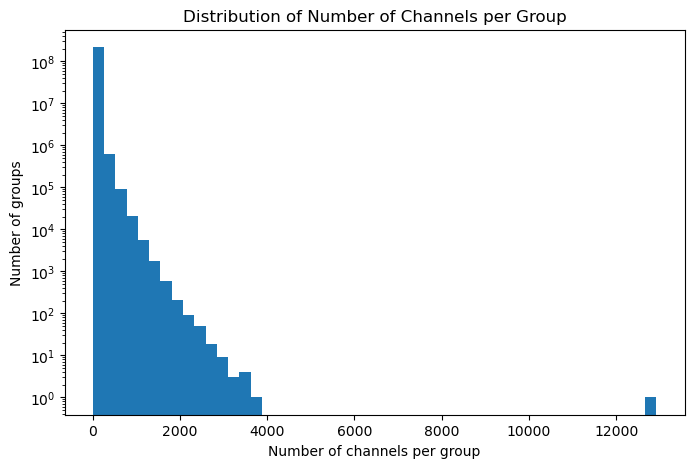

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

groups_num_channels_path = (MODELS_DIR / "groups_num_channels.tsv.gz").resolve()
n_channels = pd.read_csv(
    groups_num_channels_path,
    sep="\t",
    compression="infer"
)

plt.figure(figsize=(8, 5))
plt.hist(n_channels["num_channels"], log=True, bins=50)
plt.xlabel("Number of channels per group")
plt.ylabel("Number of groups")
plt.title("Distribution of Number of Channels per Group")
plt.show()

### 2.3.2 Export plots for the website

We export the histogram data as JSON files to be used in the web page of the data story.

In [ ]:
OUT_DIR = "web/public/data"

gna_path = (MODELS_DIR / "groups_num_authors.tsv.gz").resolve()
gnc_path = (MODELS_DIR / "groups_num_channels.tsv.gz").resolve()
gtc_path = (MODELS_DIR / "groups_total_comments.tsv.gz").resolve()

export_group_histograms(
    groups_num_authors_path=gna_path,
    groups_total_comments_path=gtc_path,
    groups_num_channels_path=gnc_path,
    out_dir=OUT_DIR,
)


## 2.4 Group features

We compute additional features for each group to better understand their commenting behavior. Specifically, we calculate:
- Channel diversity: This metric measures how evenly the comments are distributed across different channels. A high channel diversity indicates that the group comments on many different channels rather than concentrating their comments on a few. A low channel diversity suggest that the group is more fidelitous to a small set of channels.
- Category diversity: This metric quantifies the diversity of content categories that the group comments on. A high category entropy indicates that the group comments on a wide range of content categories.

To compute these features, we process the groups_channelid_numc.tsv.gz file. For each group, we gather the number of comments per channel and use this information to calculate the channel diversity using normalized entropy. We also map each channel to its content category using the df_channels.tsv file and compute the category diversity in a similar manner.

Remark:
At first we computed fidelity as 1 - normalized_entropy, but later we decided to just use normalized_entropy directly so that higher values indicate more diversity (as for category entropy). We change the naming accordingly except in some part of the code and for the naming of some files.

### 2.4.1 Building group features

Here is the code to compute the group features and write them to a new TSV file.

In [ ]:
groups_path = (MODELS_DIR / "groups_channelid_numc.tsv.gz").resolve()
channels_path = (RAW_DIR / "df_channels_en.tsv.gz").resolve()
out_path = (MODELS_DIR / "groups_features.tsv.gz").resolve()

build_group_features(
    groups_path=groups_path,
    channels_path=channels_path,
    out_path=out_path,
    total_rows=3_239_637_783,  # whatever we used as total_rows
)


### 2.4.2 Visualizing group features

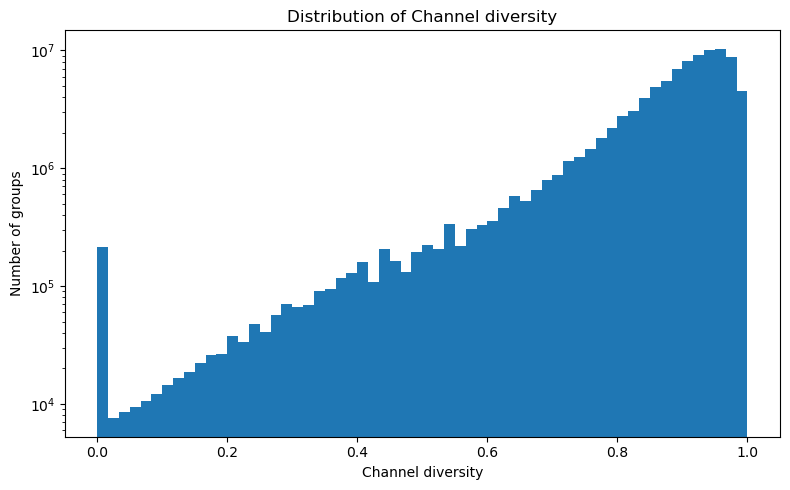

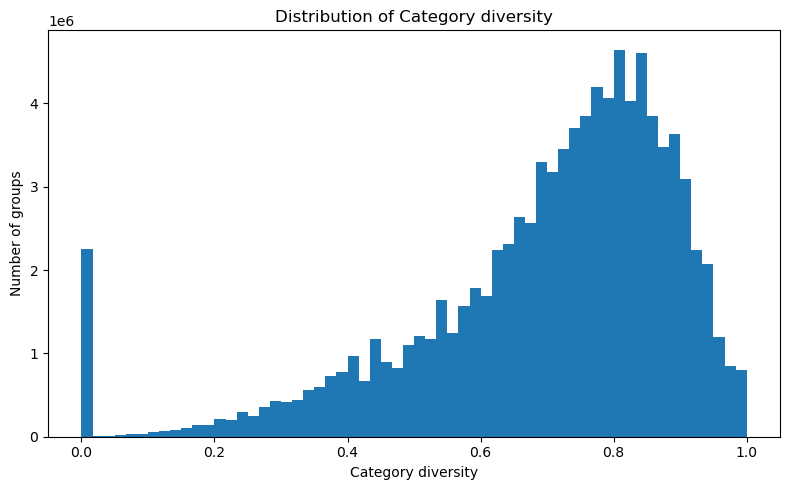

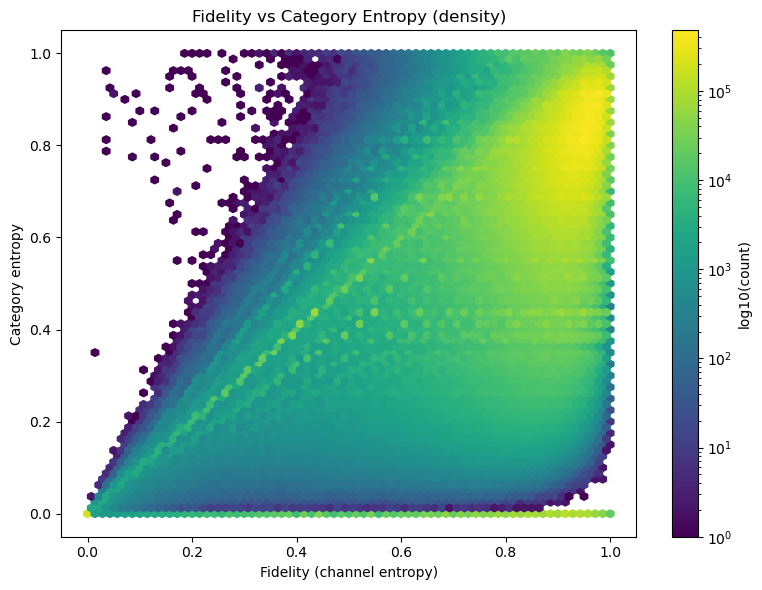

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fp = (MODELS_DIR / "groups_features.tsv.gz").resolve()

feat = pd.read_csv(fp, sep="\t", compression="infer")

feat = feat[(feat["total_comments"] > 10) & (feat["num_channels"] < 1000)]

plt.figure(figsize=(8, 5))
plt.hist(feat["fidelity"], bins=60, log=True)
plt.xlabel("Channel diversity")
plt.ylabel("Number of groups")
plt.title("Distribution of Channel diversity")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(feat["category_entropy"], bins=60)
plt.xlabel("Category diversity")
plt.ylabel("Number of groups")
plt.title("Distribution of Category diversity")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
hb = plt.hexbin(feat["fidelity"], feat["category_entropy"], gridsize=70, bins="log")
plt.xlabel("Fidelity (channel entropy)")
plt.ylabel("Category entropy")
plt.title("Fidelity vs Category Entropy (density)")
cb = plt.colorbar(hb)
cb.set_label("log10(count)")
plt.tight_layout()
plt.show()

## 2.4.3 Export group features for the website

In [ ]:
OUT_DIR = "web/public/data"

fp = (MODELS_DIR / "groups_features.tsv.gz").resolve()

export_feature_distributions(
    features_path=fp,
    out_dir=OUT_DIR,
    min_tc=10,
    max_tc=1000,
)

In [ ]:
import pandas as pd
import numpy as np
import json
import os

OUT_DIR = "web/public/data"
os.makedirs(OUT_DIR, exist_ok=True)

fp = (MODELS_DIR / "groups_features.tsv.gz").resolve()

feat = pd.read_csv(fp, sep="\t", compression="infer")
for c in ["total_comments","num_channels","fidelity","category_entropy"]:
    feat[c] = pd.to_numeric(feat[c], errors="coerce")

df = feat[(feat["total_comments"] >= 10) & (feat["total_comments"] < 1000)].dropna(
    subset=["fidelity","category_entropy","num_channels"]
)

# Fidelity (0..1) vs Category entropy (0..1)
export_heatmap_2d(
    x=df["fidelity"].to_numpy(),
    y=df["category_entropy"].to_numpy(),
    xbins=np.linspace(0, 1, 120),
    ybins=np.linspace(0, 1, 120),
    out_dir=OUT_DIR,
    out_name="fidelity_vs_category_entropy_heatmap.json"
)

# Num channels (log-ish) vs Category entropy
x = df["num_channels"].to_numpy()
x = x[x > 0]
export_heatmap_2d(
    x=np.log10(df["num_channels"].to_numpy()),
    y=df["category_entropy"].to_numpy(),
    xbins=np.linspace(np.log10(1), np.log10(1000), 120),
    ybins=np.linspace(0, 1, 120),
    out_dir=OUT_DIR,
    out_name="log_num_channels_vs_category_entropy_heatmap.json"
)

## 2.5 K-means clustering of groups

To cluster the groups based on their features -> fidelity, category entropy, and number of channels, we use the K-means clustering algorithm. This helps us identify distinct profiles of commenting behavior among the groups. Based on our analysis, K=10 clusters is a good choice allowing to get meaningful profiles without overfitting.

### 2.5.1 K-means clustering

In [ ]:
features_path = (MODELS_DIR / "groups_features.tsv.gz").resolve()
clusters_path = (MODELS_DIR / "groups_kmeans_10.tsv.gz").resolve()

run_kmeans_on_groups(
    features_path=features_path,
    out_clusters_path=clusters_path,
    K=10,
    min_tc=10,
    max_tc=1000,
)


In [ ]:
authors_path = (MODELS_DIR / "groups_num_authors.tsv.gz").resolve()
clusters_path = (MODELS_DIR / "groups_kmeans_10.tsv.gz").resolve()
out_path = (MODELS_DIR / "kmeans_cluster_people_share.tsv").resolve()

summarize_kmeans_cluster_people_share(
    clusters_path=clusters_path,
    authors_path=authors_path,
    out_path=out_path,
)


### 2.5.2 Visualizing K-means clusters

In [ ]:
features_path = (MODELS_DIR / "groups_features.tsv.gz").resolve()
clusters_path = (MODELS_DIR / "groups_kmeans_15_1000.tsv.gz").resolve()
plot_kmeans_clusters(
    features_path=features_path,
    clusters_path=clusters_path,
    min_tc=10,
    max_tc=1000,
    max_points=300_000,
)


### 2.5.3 Export K-means plots for the website

In [ ]:

export_kmeans_explorer_assets(
    features_path=features_path,
    out_dir="web/public/data/kmeans_explorer",
    min_tc=10,
    max_tc=1000,
    sample_size=120_000,
    K_max=10,
)


In [ ]:
export_kmeans_people_share_json(
    people_share_tsv="../Dataset/custom_3/kmeans_cluster_people_share.tsv",
    json_out="web/public/data/kmeans_cluster_people_share.json",
    K=10,
)

   cluster  n_groups  n_authors  share_groups  share_authors
0        0  32085826   32099282      0.322556       0.320027
1        1   5488846    5527936      0.055179       0.055113
2        2  20095311   20096772      0.202016       0.200363
3        3    921927     921972      0.009268       0.009192
4        4   9512087    9512552      0.095624       0.094839
5        5  10618475   10620693      0.106747       0.105887
6        6  12584382   12598875      0.126510       0.125610
7        7   2846797    2906713      0.028619       0.028980
8        8   1768504    2465349      0.017779       0.024579
9        9   3551556    3551738      0.035703       0.035410
✅ wrote kmeans_cluster_people_share.json


## 2.6 Category analysis of profiles

### 2.6.1 Total comments per group/category

In [ ]:
gp = (MODELS_DIR / "groups_channelid_numc.tsv.gz").resolve()
ch = (RAW_DIR / "df_channels_en.tsv.gz").resolve()
out = (MODELS_DIR / "groups_category_numc.tsv.gz").resolve()
category_analysis_for_groups(
    groups_path=gp,
    channels_path=ch,
    out_path=out,
    total_lines=3_509_000_000,
)
